## Load dataset

In [1]:
import pandas as pd
import re
from PString import PString

In [2]:
df = pd.read_csv('pronunciations/pronunciation_sp.csv')
df.head()

,word,category,pronunciation
0,a,artigo,a
1,a,preposição,a
2,á-bê-cê,nome masculino,ˌa.bˌe.sˈe
3,a-pro·pó·si·to,nome masculino,a.pɾo.pˈɔ.zi.tʊ
4,à-von·ta·de,nome masculino,ˌa.võ.tˈa.dʒi


In [3]:
df.dropna(inplace=True, subset=['word', 'pronunciation'])
df.drop_duplicates(inplace=True, subset=['word'])
df.shape

(53397, 3)

In [4]:
df['pronunciation'] = df['pronunciation'].apply(lambda v: v.split('$')[0].strip() if '$' in v else v.strip())

## Clean dataset

When manipulating the dataset, some inconsistencies were detected. These are addressed below.

In [5]:
# double pronunciations ("ou" == "or" in English)
idx = df.loc[df['pronunciation'].str.contains(' ou')].index
print(df.loc[idx].shape)
df.loc[idx].head()

(686, 3)


,word,category,pronunciation
204,a·be·ta,nome feminino,a.bˈe.tə ou a.bˈɛ.tə
209,a·bi·be,nome masculino,a.bˈi.bi ou a.bˈi.bi
401,ab·sen·tis·ta,nome masculino,a.bi.sẽ.tʃˈis.tə ou a.bi.sẽ.tʃˈis.tə
447,abs·tra·ção,nome feminino,abs.tɾa.sˈə̃w ou abs.tɾa.sˈə̃w
457,abs·tra·to,adjetivo,abs.tɾˈa.tʊ ou abs.tɾˈa.tʊ


In [6]:
# keep only first pronunciation
df.loc[idx, 'pronunciation'] = df.loc[idx, 'pronunciation'].apply(lambda v: v.split('ou')[0].strip())

In [7]:
# some words don't have a valid transcription
# instead their pronunciation appears as "ou"
# which is incorrect
idx = df.loc[df['pronunciation'].str.contains('ou')].index
print(df.loc[idx].shape)
df.loc[idx].head()

(26, 3)


,word,category,pronunciation
7310,ba·by-sit·ter,nome masculino,ou
12390,chauf·feur,nome masculino,ou
15835,cor·don-bleu,nome masculino,ou
19794,de·sig·ner,nome masculino,ou
28998,free·lan·ce,nome masculino,ou


In [8]:
# remove these invalid words
df = df.loc[~df.index.isin(idx)]

In [9]:
# fix pronunciations
print(df.loc[18754]) # wrong suffix
df.at[18754, 'pronunciation'] = 'dʒis.ko.lˈa.ʒẽj' 

print()
print(df.loc[40017]) # missing suffix
df.at[40017, 'pronunciation'] = 'mi.kɾo.voʊtʃ'

print()
print(df.loc[44141]) # wrong phoneme (/c/ instead of /k/)
df.at[44141, 'pronunciation'] = 'pˌə.nʊ.krˈu'

word                     des·co·la·gem
category                 nome feminino
pronunciation    dʒis.ko.lˈa.ʒẽjʌ̃j_m
Name: 18754, dtype: object

word                mi·cro·volt
category         nome masculino
pronunciation           mi.kɾo.
Name: 40017, dtype: object

word                  pa·no-cru
category         nome masculino
pronunciation       pˌə.nʊ.crˈu
Name: 44141, dtype: object


## Preprocess dataset

In [10]:
df['pronunciation_clean'] = df['pronunciation'].apply(lambda v: PString(re.sub('[ ˌ.ˈ_\-]', '', v)))
df['word_clean'] = df['word'].apply(lambda v: re.sub('[ˌ·ˈ\'_]', '', v).replace(' ', '-').lower())
df.head()

,word,category,pronunciation,pronunciation_clean,word_clean
0,a,artigo,a,a,a
2,á-bê-cê,nome masculino,ˌa.bˌe.sˈe,abese,á-bê-cê
3,a-pro·pó·si·to,nome masculino,a.pɾo.pˈɔ.zi.tʊ,apɾopɔzitʊ,a-propósito
4,à-von·ta·de,nome masculino,ˌa.võ.tˈa.dʒi,avõtadʒi,à-vontade
5,a·a,nome feminino,a.ˈa,aa,aa


In [11]:
def get_chars_list(series):
    return series.apply(list).apply(pd.Series).stack().unique()

In [12]:
tokens = get_chars_list(df['pronunciation_clean'])
print(f'Tokens: {tokens}')
print(f'Number of tokens: {len(tokens)}')

chars = get_chars_list(df['word_clean'])
print(f'Chars: {chars}')
print(f'Number of chars: {len(chars)}')

Tokens: ['a' 'b' 'e' 's' 'p' 'ɾ' 'o' 'ɔ' 'z' 'i' 't' 'ʊ' 'v' 'õ' 'dʒ' 'w' 'x'
 'tʃ' 'g' 'd' 'j' 'ə' 'k' 'ə̃' 'ʃ' 'ʒ' 'f' 'm' 'ẽ' 'n' 'u' 'l' 'r' 'ʎ'
 'ɛ' 'ɛ̃' 'ɲ' 'ũ' 'ĩ' 'ɨ' 'ɐ̃' 'h' 'ŋ' 'ɫ' 'ɔ̃']
Number of tokens: 45
Chars: ['a' 'á' '-' 'b' 'ê' 'c' 'p' 'r' 'o' 'ó' 's' 'i' 't' 'à' 'v' 'n' 'd' 'e'
 'l' 'g' 'x' 'j' 'f' 'm' 'u' 'ç' 'ã' 'z' 'h' 'q' 'ô' 'é' 'í' 'ú' 'â' 'y'
 'õ' 'w' 'k']
Number of chars: 39


In [13]:
df[['word_clean','pronunciation_clean']].to_csv('pronunciations/pronunciation_sp_clean.csv', index=False)
df['word_clean'].to_csv('pronunciations/pronunciation_sp_clean.txt', index=False, header=False)

In [14]:
df_val = df.sample(frac=0.1, random_state=82)
df_val.shape

(5337, 5)

In [66]:
df_val['word_clean'].to_csv('pronunciations/pronunciation_sp_val.txt', index=False, header=False)

## G2P

### Epitran G2P

In [15]:
from pandarallel import pandarallel
import epitran

pandarallel.initialize(progress_bar=False)

def epitran_g2p(text, epi):
    """
    Roda e pré-processa g2p do epitran para uma frase
    """
    return epi.transliterate(u'{}'.format(text))

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [16]:
epi = epitran.Epitran('por-Latn')

In [17]:
df_val['epitran_pronunciation'] = df_val.parallel_apply(lambda row: epitran_g2p(row['word_clean'], epi), axis=1) # too slow
df_val['epitran_pronunciation'].head()

43758           pɐko
12375    kɐʃko-pɾɛto
44434          pɐɾɡo
46213          piʃtõ
51375      ʁɛɡɐtɛjɾɐ
Name: epitran_pronunciation, dtype: object

In [18]:
df_val['epitran_pronunciation_clean'] = df_val['epitran_pronunciation'].apply(lambda v: v.replace('-', ''))
df_val['epitran_pronunciation_clean'].head()

43758          pɐko
12375    kɐʃkopɾɛto
44434         pɐɾɡo
46213         piʃtõ
51375     ʁɛɡɐtɛjɾɐ
Name: epitran_pronunciation_clean, dtype: object

### Read G2P transcripts

In [19]:
import subprocess
from phonecodes.src.phonecodes import xsampa2ipa

def translate_xsampa(text):
    """
    Transforma XSAMPA para IPA (saída do falabrasil é em XSAMPA)
    """
    return ' '.join('_'.join(xsampa2ipa(char, 'por-BR') for char in word.split('_')) for word in text.split())

In [20]:
def clean_espeak_transcript(transcript):
    transcript = transcript.strip().replace('ɾ_ə', 'ɾ')
    return re.sub('__(a_ɡ_u_d_ʊ|s_i_r_k_ũ_ŋ_f_l_ɛ_k_s_ʊ|ɡ_r_a_v_i|tʃ_iʊ)_', '', transcript).replace('_', '')

def remove_whitespaces(transcript):
    return translate_xsampa(transcript).replace(' ', '')

In [21]:
df_espeak = pd.read_csv('pronunciations/pronunciation_sp_val_espeak.csv', header=None)
df_espeak.columns = ['word_clean', 'espeak_pronunciation']
df_espeak.head()

,word_clean,espeak_pronunciation
0,pacho,p_a_ʃ_ʊ
1,chasco-preto,ʃ_a_s_k_ʊ_p_r_e_t_ʊ
2,pargo,p_a_ɾ_ə_ɡ_ʊ
3,pistom,p_i_s_t_o_ŋ
4,regateira,x_e_ɡ_a_t_eɪ_ɾ_æ


In [22]:
df_espeak['espeak_pronunciation_clean'] = df_espeak['espeak_pronunciation'].apply(clean_espeak_transcript)
df_espeak['espeak_pronunciation_clean'].head()

0          paʃʊ
1    ʃaskʊpretʊ
2         paɾɡʊ
3        pistoŋ
4     xeɡateɪɾæ
Name: espeak_pronunciation_clean, dtype: object

In [23]:
df_falabrasil = pd.read_csv('pronunciations/pronunciation_sp_val_falabrasil.csv', header=None)
df_falabrasil.columns = ['word_clean', 'falabrasil_pronunciation']
df_falabrasil.head()

,word_clean,falabrasil_pronunciation
0,pacho,p a S u
1,chasco-preto,S a s k u p r e t u
2,pargo,p a R g u
3,pistom,p i s t o~
4,regateira,R e g a t e j r a


In [24]:
df_falabrasil['falabrasil_pronunciation_clean'] = df_falabrasil['falabrasil_pronunciation'].apply(remove_whitespaces)
df_falabrasil['falabrasil_pronunciation_clean'].head()

0          paʃu
1    ʃaskupretu
2         paʁɡu
3        pistõ
4     ʁeɡatejra
Name: falabrasil_pronunciation_clean, dtype: object

In [25]:
df_phonetisaurus = pd.read_csv('pronunciations/pronunciation_sp_val_phonetisaurus.csv', header=None)
df_phonetisaurus.columns = ['word_clean', 'phonetisaurus_pronunciation']
df_phonetisaurus.head()

,word_clean,phonetisaurus_pronunciation
0,pacho,p a ʃ o
1,chasco-preto,ʃ a s k o p ʁ e t o
2,pargo,p a ʁ g o
3,pistom,p i s t o m
4,regateira,ʁ e g a t e i ʁ a


In [26]:
df_phonetisaurus['phonetisaurus_pronunciation_clean'] = df_phonetisaurus['phonetisaurus_pronunciation'].\
apply(lambda v: v.replace('ˈ', '')).apply(remove_whitespaces)
df_phonetisaurus['phonetisaurus_pronunciation_clean'].head()

0          paʃo
1    ʃaskopʁeto
2         paʁɡo
3        pistom
4     ʁeɡateiʁa
Name: phonetisaurus_pronunciation_clean, dtype: object

In [27]:
df_val = pd.merge(df_val, df_espeak, left_on='word_clean', right_on='word_clean')
df_val = pd.merge(df_val, df_falabrasil, left_on='word_clean', right_on='word_clean')
df_val = pd.merge(df_val, df_phonetisaurus, left_on='word_clean', right_on='word_clean')
df_val.head()

,word,category,pronunciation,pronunciation_clean,word_clean,epitran_pronunciation,epitran_pronunciation_clean,espeak_pronunciation,espeak_pronunciation_clean,falabrasil_pronunciation,falabrasil_pronunciation_clean,phonetisaurus_pronunciation,phonetisaurus_pronunciation_clean
0,pa·cho,nome masculino,pˈa.ʃʊ,paʃʊ,pacho,pɐko,pɐko,p_a_ʃ_ʊ,paʃʊ,p a S u,paʃu,p a ʃ o,paʃo
1,chas·co-pre·to,nome masculino,ʃˌas.kʊ.pɾˈe.tʊ,ʃaskʊpɾetʊ,chasco-preto,kɐʃko-pɾɛto,kɐʃkopɾɛto,ʃ_a_s_k_ʊ_p_r_e_t_ʊ,ʃaskʊpretʊ,S a s k u p r e t u,ʃaskupretu,ʃ a s k o p ʁ e t o,ʃaskopʁeto
2,par·go,nome masculino,pˈaɾ.gʊ,paɾgʊ,pargo,pɐɾɡo,pɐɾɡo,p_a_ɾ_ə_ɡ_ʊ,paɾɡʊ,p a R g u,paʁɡu,p a ʁ g o,paʁɡo
3,pis·tom,nome masculino,pis.tˈõ,pistõ,pistom,piʃtõ,piʃtõ,p_i_s_t_o_ŋ,pistoŋ,p i s t o~,pistõ,p i s t o m,pistom
4,re·ga·tei·ra,nome feminino,xe.ga.tˈej.ɾə,xegatejɾə,regateira,ʁɛɡɐtɛjɾɐ,ʁɛɡɐtɛjɾɐ,x_e_ɡ_a_t_eɪ_ɾ_æ,xeɡateɪɾæ,R e g a t e j r a,ʁeɡatejra,ʁ e g a t e i ʁ a,ʁeɡateiʁa


## CER analysis

In [29]:
from jiwer import cer

In [30]:
def get_cer_df(df, ref_col, cols):
    d = {}
    for col in cols:
        d[col] = cer(df[ref_col].tolist(), df[col].tolist())
    return d

In [31]:
cols = [
    'espeak_pronunciation_clean', 
    'falabrasil_pronunciation_clean', 
    'epitran_pronunciation_clean', 
    'phonetisaurus_pronunciation_clean'
]

cols_with_ref = ['pronunciation_clean'] + cols
df_val[cols_with_ref] = df_val[cols_with_ref].applymap(lambda v: PString(v))

In [32]:
cer_s = pd.Series(get_cer_df(df_val, 'pronunciation_clean', cols))
print(cer_s)

espeak_pronunciation_clean           0.295518
falabrasil_pronunciation_clean       0.265309
epitran_pronunciation_clean          0.518693
phonetisaurus_pronunciation_clean    0.442504
dtype: float64


In [33]:
espeak_list = get_chars_list(df_val['espeak_pronunciation_clean'])
falabrasil_list = get_chars_list(df_val['falabrasil_pronunciation_clean'])
epitran_list = get_chars_list(df_val['epitran_pronunciation_clean'])
phonetisaurus_list = get_chars_list(df_val['phonetisaurus_pronunciation_clean'])

print('Number of chars and chars list:')
print(f'espeak: {len(espeak_list)} {espeak_list}')
print(f'falabrasil: {len(falabrasil_list)} {falabrasil_list}')
print(f'epitran: {len(epitran_list)} {epitran_list}')
print(f'phonetisaurus {len(phonetisaurus_list)} {phonetisaurus_list}')

Number of chars and chars list:
espeak: 39 ['p' 'a' 'ʃ' 'ʊ' 's' 'k' 'r' 'e' 't' 'ɾ' 'ɡ' 'i' 'o' 'ŋ' 'x' 'ɪ' 'æ' 'b'
 'l' 'd' 'dʒ' 'y' 'ɐ̃' 'm' 'z' 'ʒ' 'tʃ' 'u' 'v' 'ʊ̃' 'ɔ' 'f' 'n' 'ɛ' 'ɲ'
 'w' 'j' 'ũ' 'õ']
falabrasil: 38 ['p' 'a' 'ʃ' 'u' 's' 'k' 'r' 'e' 't' 'ʁ' 'ɡ' 'i' 'õ' 'j' 'ẽ' 'b' 'l' 'd'
 'dʒ' 'ã' 'm' 'ɛ' 'o' 'χ' 'z' 'ʒ' 'w' 'tʃ' 'ĩ' 'v' 'ũ' 'w̃' 'f' 'n' 'ɲ'
 'ɔ' 'ʎ' 'j̃']
epitran: 42 ['p' 'ɐ' 'k' 'o' 'ʃ' 'ɾ' 'ɛ' 't' 'ɡ' 'i' 'õ' 'ʁ' 'j' 'n' 'b' 'l' 'd' 'm'
 'z' 'ʒ' 'a' 'w' 'u' 'v' 's' 'ɐ̃' 'w̃' 'f' 'kʷ' 'e' 'ɔ' 'j́' 'ɛ̃' 'ɡʷ' 'ẽ'
 'ĩ' 'dʒ' 'lʒ' 'ẃ' 'ɡ̃' 'j̃' 'ũ']
phonetisaurus 34 ['p' 'a' 'ʃ' 'o' 's' 'k' 'ʁ' 'e' 't' 'ɡ' 'i' 'm' 'n' 'b' 'ɫ' 'd' 'ʒ' 'u'
 'z' 'v' 'ɐ̃' 'f' 'ɲ' 'ʎ' 'ɛ' 'ã' 'ɔ' 'ẽ' 'õ' 'dʒ' 'ʀ' 'ɾ' 'õ' 'w']


In [34]:
falabrasil_xsampa = get_chars_list(df_falabrasil['falabrasil_pronunciation'].apply(str.split))
print('falabrasil (X-SAMPA):', len(falabrasil_xsampa), falabrasil_xsampa)

falabrasil (X-SAMPA): 38 ['p' 'a' 'S' 'u' 's' 'k' 'r' 'e' 't' 'R' 'g' 'i' 'o~' 'j' 'e~' 'b' 'l' 'd'
 'dZ' 'a~' 'm' 'E' 'o' 'X' 'z' 'Z' 'w' 'tS' 'i~' 'v' 'u~' 'w~' 'f' 'n' 'J'
 'O' 'L' 'j~']


In [35]:
reference_tokens = ['p', 'b', 't', 'd', 'k', 'ɡ', 'tʃ', 'dʒ', 'f', 'v', 's', 'z', 'ʃ', 'ʒ', 
                    'χ', 'ɣ', 'h', 'ɦ', 'm', 'n', 'ɲ', 'ɾ', 'r', 'ɹ', 'l', 'ʎ',
                   'i', 'ĩ', 'ɪ', 'e', 'ẽ', 'ɛ', 'ə', 'ã', 'a', 'ʊ', 'ũ', 'u', 'õ', 'o', 'ɔ']
print(f'reference tokens: {len(reference_tokens)} {reference_tokens}')
print(f'dictionnary tokens: {len(tokens)} {tokens}')

reference tokens: 41 ['p', 'b', 't', 'd', 'k', 'ɡ', 'tʃ', 'dʒ', 'f', 'v', 's', 'z', 'ʃ', 'ʒ', 'χ', 'ɣ', 'h', 'ɦ', 'm', 'n', 'ɲ', 'ɾ', 'r', 'ɹ', 'l', 'ʎ', 'i', 'ĩ', 'ɪ', 'e', 'ẽ', 'ɛ', 'ə', 'ã', 'a', 'ʊ', 'ũ', 'u', 'õ', 'o', 'ɔ']
dictionnary tokens: 45 ['a' 'b' 'e' 's' 'p' 'ɾ' 'o' 'ɔ' 'z' 'i' 't' 'ʊ' 'v' 'õ' 'dʒ' 'w' 'x'
 'tʃ' 'g' 'd' 'j' 'ə' 'k' 'ə̃' 'ʃ' 'ʒ' 'f' 'm' 'ẽ' 'n' 'u' 'l' 'r' 'ʎ'
 'ɛ' 'ɛ̃' 'ɲ' 'ũ' 'ĩ' 'ɨ' 'ɐ̃' 'h' 'ŋ' 'ɫ' 'ɔ̃']


In [36]:
print(f'dictionnary tokens not in reference: {set(tokens) - set(reference_tokens)}')
print(f'espeak tokens not in reference: {set(espeak_list) - set(reference_tokens)}')
print(f'falabrasil tokens not in reference: {set(falabrasil_list) - set(reference_tokens)}')
print(f'epitran tokens not in reference: {set(epitran_list) - set(reference_tokens)}')
print(f'phonetisaurus tokens not in reference: {set(phonetisaurus_list) - set(reference_tokens)}')

dictionnary tokens not in reference: {'ɐ̃', 'ə̃', 'ɛ̃', 'ɫ', 'j', 'w', 'x', 'ŋ', 'ɔ̃', 'õ', 'ɨ', 'g'}
espeak tokens not in reference: {'ɐ̃', 'æ', 'y', 'ʊ̃', 'j', 'w', 'x', 'ŋ', 'õ'}
falabrasil tokens not in reference: {'ʁ', 'w̃', 'j̃', 'j', 'w', 'ã', 'õ'}
epitran tokens not in reference: {'ʁ', 'j́', 'ɡ̃', 'ɐ̃', 'kʷ', 'ẃ', 'w̃', 'ũ', 'ɛ̃', 'ɐ', 'ẽ', 'j', 'ɡʷ', 'w', 'lʒ', 'j̃', 'ĩ'}
phonetisaurus tokens not in reference: {'ʁ', 'ɐ̃', 'ʀ', 'ɫ', 'w', 'õ'}


### Mapping of phonemes

In [37]:
def simplify(c):
    d = {
        'w': 'ʊ',
        'ŋ': 'n',
        'j': 'ɪ',
        'ɨ': 'i',
        'ə̃': 'ã',
        'ɐ̃': 'ã',
        'ɛ̃': 'ẽ', 
        'ɔ̃': 'õ',
        'x': 'χ',
        'g': 'ɡ',
        'y': 'i',
        'æ': 'a',
        'w̃': 'ʊ̃',
        'j̃': 'ɪ',
        'ʁ': 'χ',
        'ã': 'ã',
        'ʀ': 'χ',
        'õ': 'õ',
        'j́': 'ɪ',
        'ĩ': 'ĩ',
        'ɡʷ': 'ɡ',
        'kʷ': 'k',
        'ẃ': 'u',
        'lʲ': 'ʎ',
        'ỹ': 'ɲ',
        'ɫ': 'l',
    }
    try:
        return d[c]
    except KeyError:
        return c

In [38]:
df_val[cols_with_ref] = df_val[cols_with_ref].applymap(lambda v: ''.join(list(map(simplify, v))))
df_val[cols_with_ref].head()

,pronunciation_clean,espeak_pronunciation_clean,falabrasil_pronunciation_clean,epitran_pronunciation_clean,phonetisaurus_pronunciation_clean
0,paʃʊ,paʃʊ,paʃu,pɐko,paʃo
1,ʃaskʊpɾetʊ,ʃaskʊpretʊ,ʃaskupretu,kɐʃkopɾɛto,ʃaskopχeto
2,paɾɡʊ,paɾɡʊ,paχɡu,pɐɾɡo,paχɡo
3,pistõ,piston,pistõ,piʃtõ,pistom
4,χeɡateɪɾə,χeɡateɪɾa,χeɡateɪra,χɛɡɐtɛɪɾɐ,χeɡateiχa


In [39]:
new_cer_s = pd.Series(get_cer_df(df_val, 'pronunciation_clean', cols))
print(new_cer_s)

espeak_pronunciation_clean           0.183902
falabrasil_pronunciation_clean       0.212163
epitran_pronunciation_clean          0.459288
phonetisaurus_pronunciation_clean    0.348186
dtype: float64


### Pattern substitution

In [36]:
import re

def replace_im_with_i_nasal(text):
    def replace(match):
        return "ĩ" + match.group(1)

    pattern = r'im([pb])'
    result = re.sub(pattern, replace, text)
    return result

def replace_in_with_i_nasal(text):
    def replace(match):
        return "ĩ" + match.group(1)

    pattern = r'im([pb])'
    result = re.sub(pattern, replace, text)
    return result

def replace_ein_with_ei(text):
    def replace(match):
        return "ẽɪ" + match.group(1)

    pattern = r'eɪn([pbtdkɡtʃdʒfvszʃʒχɣhɦmnɲỹɾrɹlɫʎlʲ])'
    result = re.sub(pattern, replace, text)
    return result

def replace_ein_with_en(text):
    def replace(match):
        return "en"

    pattern = r'eɪn$'
    result = re.sub(pattern, replace, text)
    return result

def replace_e_nasal_with_ei(text):
    def replace(match):
        return "ẽɪ"

    pattern = r'ẽ(?=[pbtdkɡtʃdʒfvszʃʒχɣhɦmɾrɹlɫʎlʲ])'
    result = re.sub(pattern, replace, text)
    return result

def translate(transcript):
    transcript = replace_im_with_i_nasal(transcript)
    transcript = replace_ein_with_ei(transcript)
    transcript = replace_ein_with_en(transcript)
    transcript = replace_e_nasal_with_ei(transcript)
    return transcript

In [37]:
# df_val[cols] = df_val[cols].applymap(lambda v: translate(v))
# df_val[cols_with_ref].head()

In [38]:
# new_cer_s = pd.Series(get_cer_df(df_val, 'pronunciation_clean', cols))
# print(new_cer_s)

## Error analysis

In [40]:
df_cer = df_val.apply(lambda row: [cer(row['pronunciation_clean'], row[col]) \
                                   for col in cols
                                  ], 
                      axis=1, result_type='expand')
df_cer.columns = cols

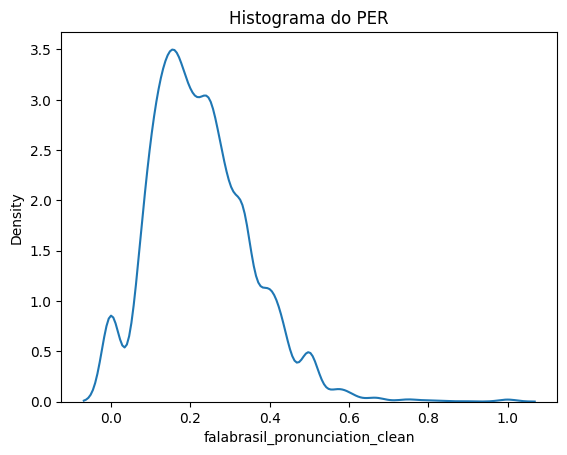

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(df_cer['falabrasil_pronunciation_clean'])
plt.title('Histograma do PER')
plt.show()

In [46]:
highest_error = df_cer[df_cer['falabrasil_pronunciation_clean'] > 0.8].index
index = df_val.loc[highest_error, ['word_clean', 'pronunciation_clean', 'falabrasil_pronunciation_clean']].index
df_val.loc[index]

,word,category,pronunciation,pronunciation_clean,word_clean,epitran_pronunciation,epitran_pronunciation_clean,espeak_pronunciation,espeak_pronunciation_clean,falabrasil_pronunciation,falabrasil_pronunciation_clean,phonetisaurus_pronunciation,phonetisaurus_pronunciation_clean
2860,hou,interjeição,ˈo,o,hou,owu,oʊu,o_w,oʊ,o w,oʊ,o u,ou
3122,e·ra,nome feminino,ˈɛ.ɾə,ɛɾə,era,ɛɾɐ,ɛɾɐ,ɛ_ɾ_æ,ɛɾa,e r a,era,e ʁ a,eχa
3130,tra·ção,nome masculino,se.lˈɛ.tʊ,selɛtʊ,tração,tɾɐsɐ̃w̃,tɾɐsãʊ̃,t_r_a_s_ɐ̃ʊ̃,trasãʊ̃,t r a s a~ w~,trasãʊ̃,t ʁ a s ɐ̃ o,tχasão
3427,dram,nome masculino,dɾˈə̃,dɾã,dram,dɾɐ̃,dɾã,d_r_ɐ̃ʊ̃,drãʊ̃,d r a~ w~,drãʊ̃,d ʁ a m,dχam
3758,cor·ta-u·nhas,nome masculino,kˌɔɾ.tə.fˈo.gʊ,kɔɾtəfoɡʊ,corta-unhas,koɾtɐ-unɐʃ,koɾtɐunɐʃ,k_ɔ_ɾ_ə_t_æ_ũ_ɲ_æ_s,kɔɾtaũɲas,k o X t a u~ J a s,koχtaũɲas,k o ʁ t a u ɲ a s,koχtauɲas
3861,he·na,nome feminino,ˈɛ.nə,ɛnə,hena,ɛnɐ,ɛnɐ,e_n_æ,ena,e~ n a,ẽna,e n a,ena
4096,fru·ir,verbo,fɾwˈi,fɾʊi,fruir,fɾujɾ,fɾuɪɾ,f_r_u_i_r,fruir,f r u j X,fruɪχ,f ʁ u i ʁ,fχuiχ
4676,bo·é·mi·a,nome feminino,bwˈɛ.mjə,bʊɛmɪə,boémia,bowemiɐ,boʊemiɐ,b_o_ɛ_m_j_æ,boɛmɪa,b o e~ m i a,boẽmia,b o ɛ m i a,boɛmia


In [43]:
df_cer = df_val.apply(lambda row: [cer(row['pronunciation_clean'], row[col]) \
                                   for col in cols
                                  ], 
                      axis=1, result_type='expand')
df_cer.columns = cols

In [47]:
highest_error = df_cer[df_cer['falabrasil_pronunciation_clean'] > 0.7].index
index = df_val.loc[highest_error, ['word_clean', 'pronunciation_clean', 'falabrasil_pronunciation_clean']].index
df_val.loc[index]

,word,category,pronunciation,pronunciation_clean,word_clean,epitran_pronunciation,epitran_pronunciation_clean,espeak_pronunciation,espeak_pronunciation_clean,falabrasil_pronunciation,falabrasil_pronunciation_clean,phonetisaurus_pronunciation,phonetisaurus_pronunciation_clean,pronunciation_clean_standard
744,ou·trem,pronome,ˈo.tɾeɲ,otɾeɲ,outrem,owutʁɛ̃,oʊutχẽ,o_w_t_r_eɪ_ŋ,oʊtreɪn,o w t r e~ j~,oʊtrẽɪ,o u t ʁ e m,outχem,otɾeɲ
1381,po·e·ma,nome masculino,pwˈɛ.mə,pʊɛmə,poema,powɛmɐ,poʊɛmɐ,p_o_e_m_æ,poema,p o e~ m a,poẽma,p o e m a,poema,puɛma
1415,a·nu·ir,verbo,a.nwˈi,anʊi,anuir,ɐnujɾ,ɐnuɪɾ,æ_n_u_i_r,anuir,a n u j X,anuɪχ,a n u i ʁ,anuiχ,anuiʁ
2249,he·xa·no,nome masculino,e.gə.zˈə.nʊ,eɡəzənʊ,hexano,ɛzɐno,ɛzɐno,e_k_s_ɐ̃_n_ʊ,eksãnʊ,E k z a~ n u,ɛkzãnu,e k s a n o,eksano,eɡazanu
3524,glam,nome masculino,glˈam,ɡlam,glam,ɡlɐ̃,ɡlã,ɡ_l_ɐ̃ʊ̃,ɡlãʊ̃,g l a~ w~,ɡlãʊ̃,g ɫ a m,ɡlam,ɡlam
4077,or·cha·ta,nome feminino,ɔɾ.ʃˈa.tə ou ɔɾ.ʃˈa.tə,ɔɾʃatəouɔɾʃatə,orchata,oɾkɐtɐ,oɾkɐtɐ,o_ɾ_ə_ʃ_a_t_æ,oɾʃata,o X S a t a,oχʃata,o ʁ ʃ a t a,oχʃata,ɔʁʃataouɔʁʃata
4531,ru·fi·a,nome masculino,xu.fˈi.jə ou xu.fˈi.jə,χufiɪəouχufiɪə,rufia,ʁufiɐ,χufiɐ,x_u_f_i__æ,χufia,R u f i a,χufia,ʁ u f i a,χufia,χufiɪaouχufiɪa
5048,lé·ri·as,nome masculino,lˈɛ.ɾjəs ou lˈɛ.ɾjəs,lɛɾɪəsoulɛɾɪəs,lérias,leɾiɐʃ,leɾiɐʃ,l_ɛ_ɾ_j_æ_s,lɛɾɪas,l E r i a s,lɛrias,ɫ ɛ ʁ i a s,lɛχias,lɛɾɪasoulɛɾɪas
5273,sé·pi·a,nome masculino,sˈɛ.pjə ou sˈɛ.pjə,sɛpɪəousɛpɪə,sépia,sepiɐ,sepiɐ,s_ɛ_p_j_æ,sɛpɪa,s E p i a,sɛpia,s ɛ p i a,sɛpia,sɛpɪaousɛpɪa


## Standardizing

In [45]:
df_val['pronunciation_clean_standard'] = df_val['pronunciation_clean'].apply(
    lambda v: v.replace('ə̃', 'ã').replace('ə', 'a').replace('ʊ', 'u')\
    .replace('x', 'ʁ').replace('iɲ', 'ĩ').replace('ẽj', 'ẽ')
)
df_val['pronunciation_clean_standard'] = df_val['pronunciation_clean_standard'].apply(
    lambda v: re.sub(r'(.)\1+', r'\1', v))
df_val['pronunciation_clean_standard'] = df_val.apply(
    lambda row: re.sub('iz', 'ez', row['pronunciation_clean_standard']) \
    if re.search('ex[eé]', row['word_clean']) \
    else row['pronunciation_clean_standard'], axis=1)
df_val['pronunciation_clean_standard'] = df_val.apply(
    lambda row: re.sub('[ʁɾ]*$', 'ʁ', row['pronunciation_clean_standard']) \
    if re.search('[aeiou]r$', row['word_clean']) \
    else row['pronunciation_clean_standard'], axis=1)

df_val['pronunciation_clean_standard'] = df_val['pronunciation_clean_standard'].apply(
    lambda v: re.sub('ɾ$', 'ʁ', v))
df_val['pronunciation_clean_standard'] = df_val['pronunciation_clean_standard'].apply(
    lambda v: re.sub('ɾ([ptnvdmlskxfɲgzʃbʒʎhɫŋ])', r'ʁ\1', v))

df_val.loc[3024, 'pronunciation_clean_standard'] = 'mikrovowtʃ' # corrige pronuncia de microvolt
cer_standard_falabrasil = pd.Series(get_cer_df(df_val, 
                            'pronunciation_clean_standard', 
                           ['falabrasil_pronunciation_clean']
                        )
                    )
print(cer_standard_falabrasil)

falabrasil_pronunciation_clean    0.189284
dtype: float64
